In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('/content/mnist_test.csv')

In [ ]:
df.head(1)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
anom = df[:1000].copy()
clean = df[1000:].copy()

In [ ]:
for i in range(len(anom)):
  # select row from anom
  row = anom.iloc[i]
  #iterate through each element in row
  for i in range(len(row)-1):
    row[i+1] = min(255, row[i+1] + random.randint(100, 200)) # 100에서 200사이의 값을 더하고 255가 넘으면 255로 제한

In [ ]:
anom['label'] = 1
clean['label'] = 0

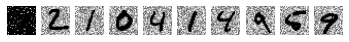

In [ ]:
 img = anom.iloc[:,1:]
 for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(img.iloc[i,:].values.reshape(28,28), cmap= 'gray_r')

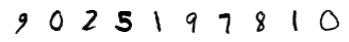

In [ ]:
img2 = clean.iloc[:, 1:]
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(img2.iloc[i,:].values.reshape(28,28), cmap = "gray_r")


In [ ]:
an_test = pd.concat([anom, clean])  # join
an_test.sample(frac=1)              # shuffle
an_test.to_csv('anom.csv')          # save

In [ ]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()        
        self.enc = nn.Sequential(
                    nn.Linear(784, 512),
                    nn.ReLU(),
                    nn.Linear(512, 256),
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                    nn.Linear(32, 16),
                    nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.ReLU()
        )
        
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

In [ ]:
import torch
import time
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import timedelta


In [ ]:
batch_size = 16
lr = 1e-2         # learning rate
# 과적합을 방지하기 위해서 규제 항목 추가 
w_d = 1e-5        # weight decay == 규제
momentum = 0.9   
epochs = 15

In [ ]:
class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        row = row.drop(labels={'label'}) # 정답값 지우기
        data = torch.from_numpy(np.array(row)/255).float() # 255로 나눈 스케일링
        return data
    
class Train_Loader(Loader):
    def __init__(self):
        super(Train_Loader, self).__init__() #상속받기 
        self.dataset = pd.read_csv( #dataset에 데이터 받아옴
                       'mnist_train.csv',
                       index_col=False
                       )

In [ ]:
train_set = Train_Loader()

train_ = torch.utils.data.DataLoader(
            train_set,
            batch_size=batch_size,
            shuffle=True,
            #num_workers=20,
            pin_memory=True,
            drop_last=True
        )

In [ ]:
train_

In [ ]:
metrics = defaultdict(list)
device = 'cuda' if torch.cuda.is_available() else 'cpu' #CPU면 CPU,  CUDA면 CUDA
model = AE()
model.to(device) #디바이스 값 넘기기
criterion = nn.MSELoss(reduction='mean') # MSE사용
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d) #과적합 방지로 w_d를 규제로 둔 SGD 소프트벡터머신

In [ ]:
model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad() #기울기 초기화
        loss.backward() # 역전파
        optimizer.step() # 기울기 기록
        running_loss += loss.item() #기록
    epoch_loss = running_loss/len(train_set) #계산
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 1/15
[LOSS] 0.0066066874660551545
Epoch Complete in 0:01:10.801009
-----------------------------------------------
[EPOCH] 2/15
[LOSS] 0.006180088043212891
Epoch Complete in 0:01:10.303636
-----------------------------------------------
[EPOCH] 3/15
[LOSS] 0.005730023300523559
Epoch Complete in 0:01:10.277500
-----------------------------------------------
[EPOCH] 4/15
[LOSS] 0.005426647049685319
Epoch Complete in 0:01:09.248625
-----------------------------------------------
[EPOCH] 5/15
[LOSS] 0.005309949309999744
Epoch Complete in 0:01:09.660523
-----------------------------------------------
[EPOCH] 6/15
[LOSS] 0.005274380775727332
Epoch Complete in 0:01:10.923399
-----------------------------------------------
[EPOCH] 7/15
[LOSS] 0.00526748725498716
Epoch Complete in 0:01:10.294237
-----------------------------------------------
[EPOCH] 8/15
[LOSS] 0.005266227888067563
Epoch Complete in 0:01:10.437106
------------------------

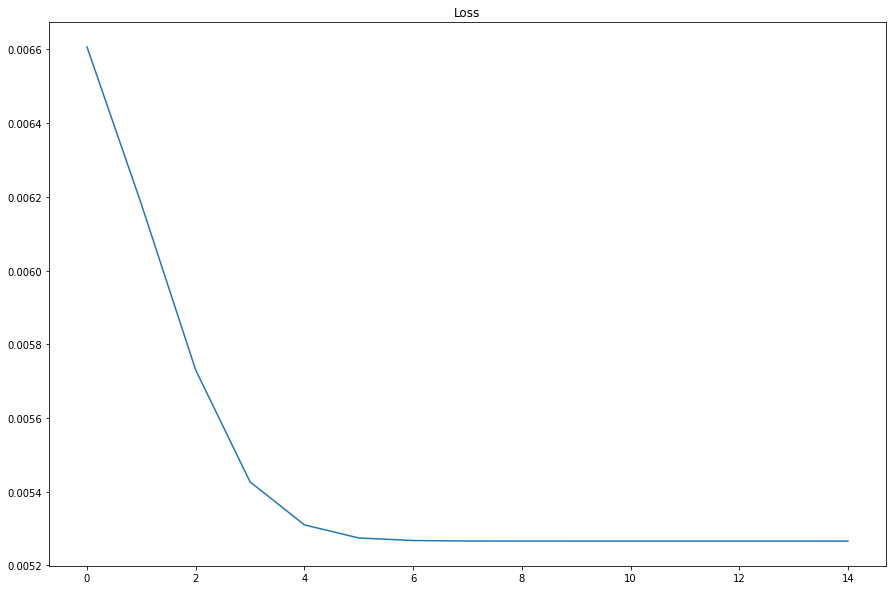

In [ ]:
_, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])

In [ ]:
model.eval()
loss_dist = []
anom = pd.read_csv('anom.csv', index_col=[0])
#for bx, data in enumerate(test_):
for i in range(len(anom)):
    data = torch.from_numpy(np.array(anom.iloc[i][1:])/255).float()
    sample = model(data.to(device))
    loss = criterion(data.to(device), sample)
    loss_dist.append(loss.item())


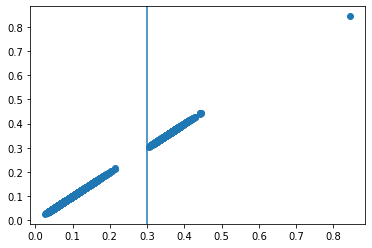

In [ ]:
loss_sc = []
for i in loss_dist:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.3, 0.0, 1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


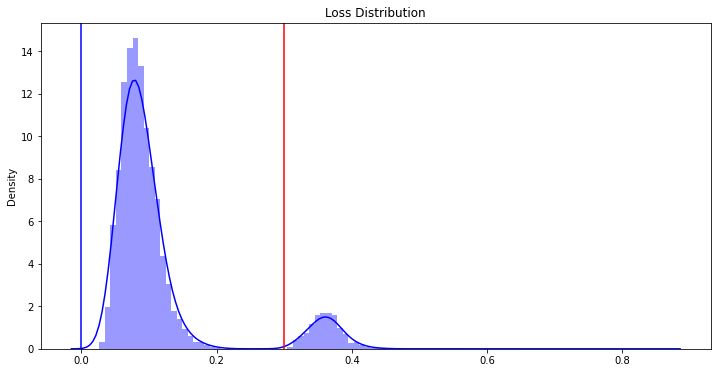

In [ ]:
lower_threshold = 0.0
upper_threshold = 0.3
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')


In [ ]:
df = pd.read_csv('anom.csv', index_col=[0])
ddf = pd.DataFrame(columns=df.columns)
tp = 0
fp = 0
tn = 0
fn = 0
total_anom = 0
for i in range(len(loss_dist)):
    total_anom += df.iloc[i]['label']
    if loss_dist[i] >= upper_threshold:
        n_df = pd.DataFrame([df.iloc[i]])
        n_df['loss'] = loss_dist[i]
        ddf = pd.concat([df,n_df], sort = True)
        if float(df.iloc[i]['label']) == 1.0:
            tp += 1
        else:
            fp += 1
    else:
        if float(df.iloc[i]['label']) == 1.0:
            fn += 1
        else:
            tn += 1
print('[TP] {}\t[FP] {}\t[MISSED] {}'.format(tp, fp, total_anom-tp))
print('[TN] {}\t[FN] {}'.format(tn, fn))


[TP] 1000	[FP] 0	[MISSED] 0
[TN] 9000	[FN] 0
